# Structural VAR Analysis of The Phillips Curve Companion Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR

Here we define a function to wrap up the results of the Dickey-Fuller test in a pandas dataframe.

In [3]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    return out 

In [5]:
df = pd.read_csv('./2024-09.csv')

# Data Pre-Processing

Data can be found on Michael McCracken's webpage on the website of the Federal Reserve Bank of St. Louis.
It includes 248 variables out of which we only keep 4. Moreover, we keep observations from right after the structural break of 1985Q1 up until the outbreak of COVID-19 in 2019Q4. The reason that we are being so strict about the structural break of 1985 is that the number of variables in our model is so small, just 4, therefore, a structural break in even one of the time-series (actually in addition to the gdp growth rate, the rate of change of Federal Funds rate had a structural break at about the same time) will have a huge impact on the model and needs to be contained. But given the small number of variables, the easy solution, dropping observations in between structural breaks, will not affect consistency of the model.

In [7]:
df = df[['sasdate', 'GDPC1','PCEPILFE','UNRATE','FEDFUNDS']]
df = df.iloc[106:242]

To make the data stationary, we will have to make the following transfomations:

- GDP -> first log-differnece;
- PCE -> second order log-difference;
- Unemployment Rate -> first difference;
- Federal Funds Rate -> first difference;

In [9]:
df['sasdate'] = pd.to_datetime(df['sasdate'])
df['GDPC1'] = np.log(df['GDPC1']).diff()
df['PCEPILFE'] = np.log(df['PCEPILFE']).diff().diff()
df['UNRATE'] = df.UNRATE.diff()
df['FEDFUNDS'] = df.FEDFUNDS.diff()

When taking differences, we will unfortunately loose the first variable, and thus we will have to drop it from the dataframe. Moreover, whe have to reindex the pandas dataframe so that indices begin from 0.

In [11]:
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)
df.rename(columns = {'GDPC1' : 'gdp', 'PCEPILFE' : 'infl', 'UNRATE' : 'unrate', 'FEDFUNDS' : 'fedfunds'}, inplace=True)

In [7]:
print(df.shape)
print(df.to_string())

(134, 5)
       sasdate       gdp      infl  unrate  fedfunds
0   1985-09-01  0.015157  0.001584 -0.1000   -0.0233
1   1985-12-01  0.007407 -0.003072 -0.1667    0.2033
2   1986-03-01  0.009294  0.003592  0.0000   -0.2766
3   1986-06-01  0.004493 -0.003906  0.1334   -0.9067
4   1986-09-01  0.009521  0.000013 -0.2000   -0.7133
5   1986-12-01  0.005350  0.001264 -0.1334    0.0600
6   1987-03-01  0.007391 -0.001798 -0.2333   -0.0467
7   1987-06-01  0.010724  0.003351 -0.3333    0.4300
8   1987-09-01  0.008634 -0.000744 -0.2667    0.1933
9   1987-12-01  0.017024  0.001192 -0.1667    0.0734
10  1988-03-01  0.005156 -0.000507 -0.1333   -0.2534
11  1988-06-01  0.013055  0.002442 -0.2333    0.4934
12  1988-09-01  0.005843 -0.000593  0.0000    0.8266
13  1988-12-01  0.013237 -0.000343 -0.1334    0.4867
14  1989-03-01  0.010113 -0.000255 -0.1333    0.9733
15  1989-06-01  0.007602 -0.001799  0.0333    0.2834
16  1989-09-01  0.007380 -0.001642  0.0000   -0.6434
17  1989-12-01  0.001968  0.001701  0

Even though statsmodels library provides very nice graphs, we wanted to test our plotting skills with the matplotlib library...

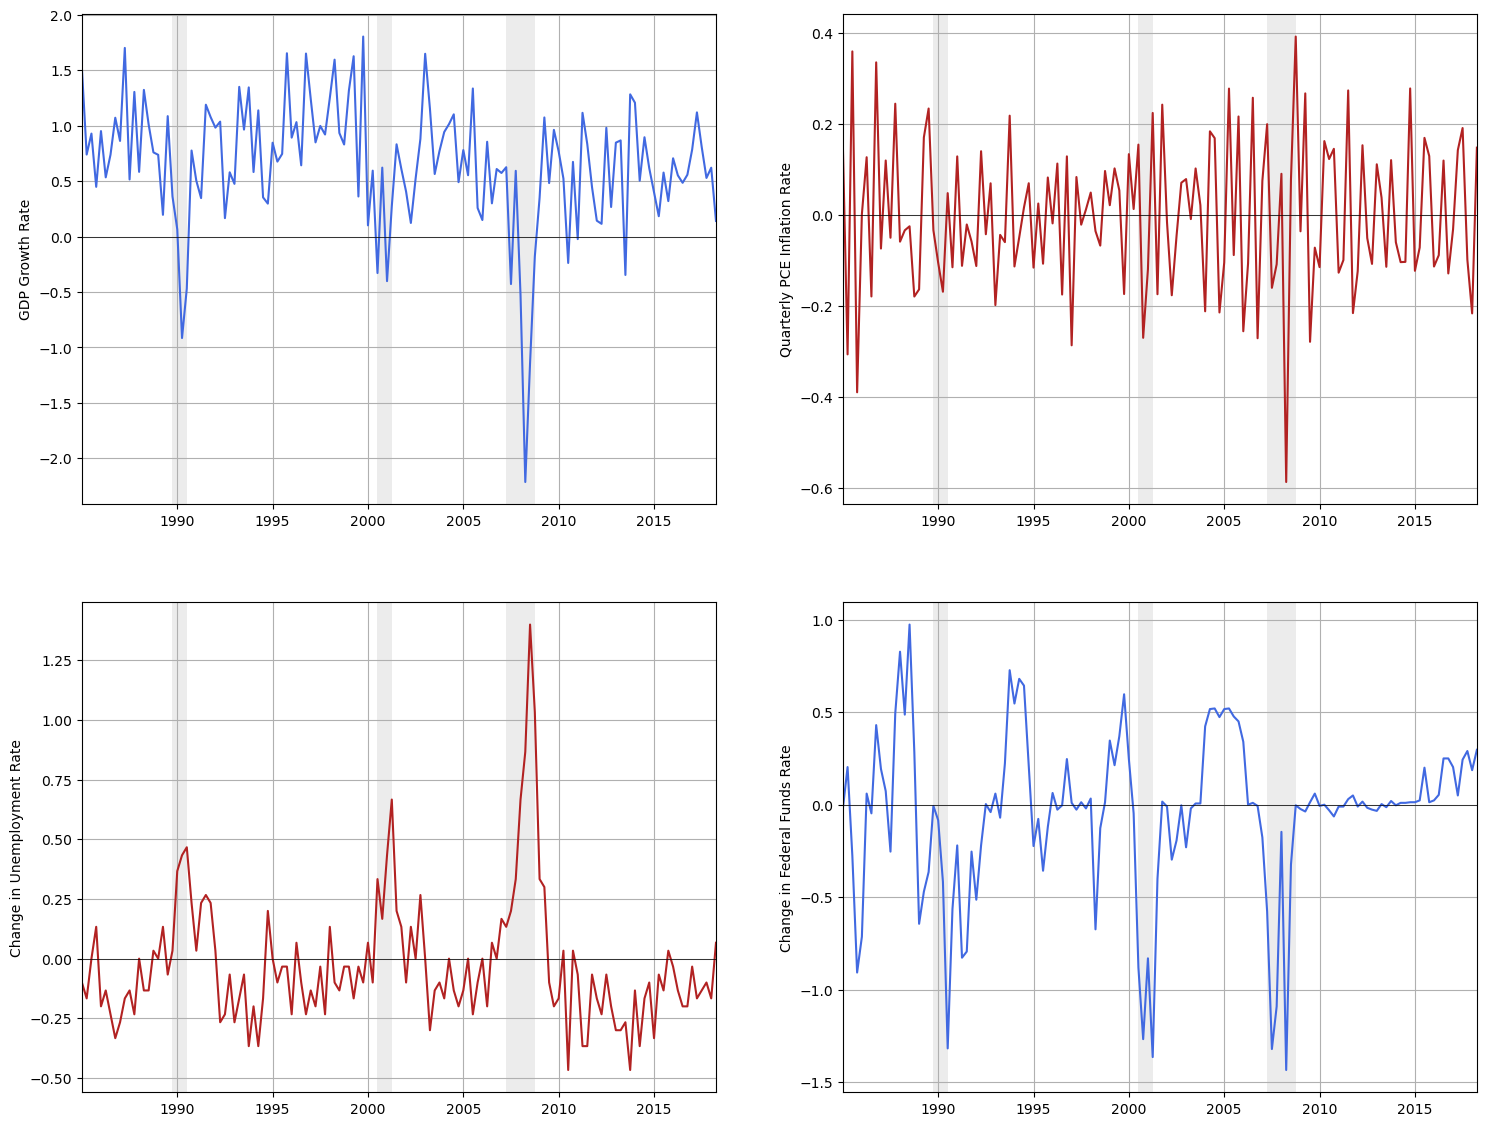

In [13]:
plt.figure(figsize=(18,14))

xticks = np.arange(20,140,20)
xlabels = [df.iloc[x,0].strftime('%Y') for x in xticks]

plt.subplot(221)
plt.plot(df.index, df.gdp*100, linewidth=1.5, color='royalblue')
plt.ylabel('GDP Growth Rate')
plt.xlim(df.index.min(), df.index.max())
plt.xticks(xticks, labels=xlabels)
plt.grid(True)
plt.axvspan(19, 22, facecolor='grey', alpha=0.15)
plt.axvspan(62, 65, facecolor='grey', alpha=0.15)
plt.axvspan(89, 95, facecolor='grey', alpha=0.15)
plt.axhline(y = 0, color = 'black', linewidth = 0.5)

plt.subplot(222)
plt.plot(df.index, df.infl*100, linewidth=1.5, color='firebrick')
plt.xlim(df.index.min(), df.index.max())
xticks = np.arange(20,140,20)
xlabels = [df.iloc[x,0].strftime('%Y') for x in xticks]
plt.ylabel('Quarterly PCE Inflation Rate')
plt.xlim(df.index.min(), df.index.max())
plt.xticks(xticks, labels=xlabels)
plt.grid(True)
plt.axvspan(19, 22, facecolor='grey', alpha=0.15)
plt.axvspan(62, 65, facecolor='grey', alpha=0.15)
plt.axvspan(89, 95, facecolor='grey', alpha=0.15)
plt.axhline(y = 0, color = 'black', linewidth = 0.5)

plt.subplot(223)
plt.plot(df.index, df.unrate, linewidth=1.5, color='firebrick')
plt.xlim(df.index.min(), df.index.max())
xticks = np.arange(20,140,20)
xlabels = [df.iloc[x,0].strftime('%Y') for x in xticks]
plt.ylabel('Change in Unemployment Rate')
plt.xlim(df.index.min(), df.index.max())
plt.xticks(xticks, labels=xlabels)
plt.grid(True)
plt.axvspan(19, 22, facecolor='grey', alpha=0.15)
plt.axvspan(62, 65, facecolor='grey', alpha=0.15)
plt.axvspan(89, 95, facecolor='grey', alpha=0.15)
plt.axhline(y = 0, color = 'black', linewidth = 0.5)

plt.subplot(224)
plt.plot(df.index, df.fedfunds, linewidth=1.5, color='royalblue')
plt.xlim(df.index.min(), df.index.max())
xticks = np.arange(20,140,20)
xlabels = [df.iloc[x,0].strftime('%Y') for x in xticks]
plt.ylabel('Change in Federal Funds Rate')
plt.xlim(df.index.min(), df.index.max())
plt.xticks(xticks, labels=xlabels)
plt.grid(True)
plt.axvspan(19, 22, facecolor='grey', alpha=0.15)
plt.axvspan(62, 65, facecolor='grey', alpha=0.15)
plt.axvspan(89, 95, facecolor='grey', alpha=0.15)
plt.axhline(y = 0, color = 'black', linewidth = 0.5)

Here we run the Dickey-Fuller test to check for unit roots, fortunately there are none.

In [15]:
print(adf_test(df.gdp, 'GDP').to_latex())
print(adf_test(df.infl, 'PCE Inflation').to_string())
print(adf_test(df.unrate, 'Unemployment').to_string())
print(adf_test(df.fedfunds, 'Federal Funds Rate').to_string())

Augmented Dickey-Fuller Test: GDP
\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
ADF test statistic & -5.067298 \\
p-value & 0.000016 \\
# lags used & 1.000000 \\
# observations & 132.000000 \\
critical value (1%) & -3.480888 \\
critical value (5%) & -2.883697 \\
critical value (10%) & -2.578586 \\
\bottomrule
\end{tabular}

Augmented Dickey-Fuller Test: PCE Inflation
ADF test statistic     -8.707740e+00
p-value                 3.661158e-14
# lags used             4.000000e+00
# observations          1.290000e+02
critical value (1%)    -3.482088e+00
critical value (5%)    -2.884219e+00
critical value (10%)   -2.578864e+00
Augmented Dickey-Fuller Test: Unemployment
ADF test statistic       -3.446081
p-value                   0.009485
# lags used               8.000000
# observations          125.000000
critical value (1%)      -3.483779
critical value (5%)      -2.884954
critical value (10%)     -2.579257
Augmented Dickey-Fuller Test: Federal Funds Rate
ADF test statistic       -5.145785

# Reduced Form Analysis

We specify the vector of variables with increasing degree of endogeneity, meaning that the first variable is the least endogenous and the last variable is the most endogenous:

$
\begin{pmatrix}
i_t \\
\pi_t \\
y_t \\
w_t
\end{pmatrix} = W_t = \sum_{k=1}^T A_k L^k W_{t-k} + \epsilon
$

In [17]:
predictors = df[['fedfunds', 'infl', 'gdp', 'unrate']]
model = VAR(predictors)

In [19]:
print(model.select_order(12))

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 1, FPE -> 2, HQIC ->  1>


We use AIC to choose the number of lags for two reasons:
First, it is true that the BIC selects the true model as the number of predictors tends to infinity, but this sample is far from high-dimensional, with only 4 variables and 133 observations, consistency is far-fetched.
Second, the model that the AIC selects survives the Ljung-Box test for residual autocorrelations.

In [21]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Nov, 2024
Time:                     13:05:21
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -28.7049
Nobs:                     132.000    HQIC:                  -29.1716
Log likelihood:           1233.21    FPE:                1.55795e-13
AIC:                     -29.4911    Det(Omega_mle):     1.19666e-13
--------------------------------------------------------------------
Results for equation fedfunds
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.014488         0.060383           -0.240           0.810
L1.fedfunds         0.616899         0.094342            6.539           0.000
L1.infl           -21.459568        19.469458           -1.102   

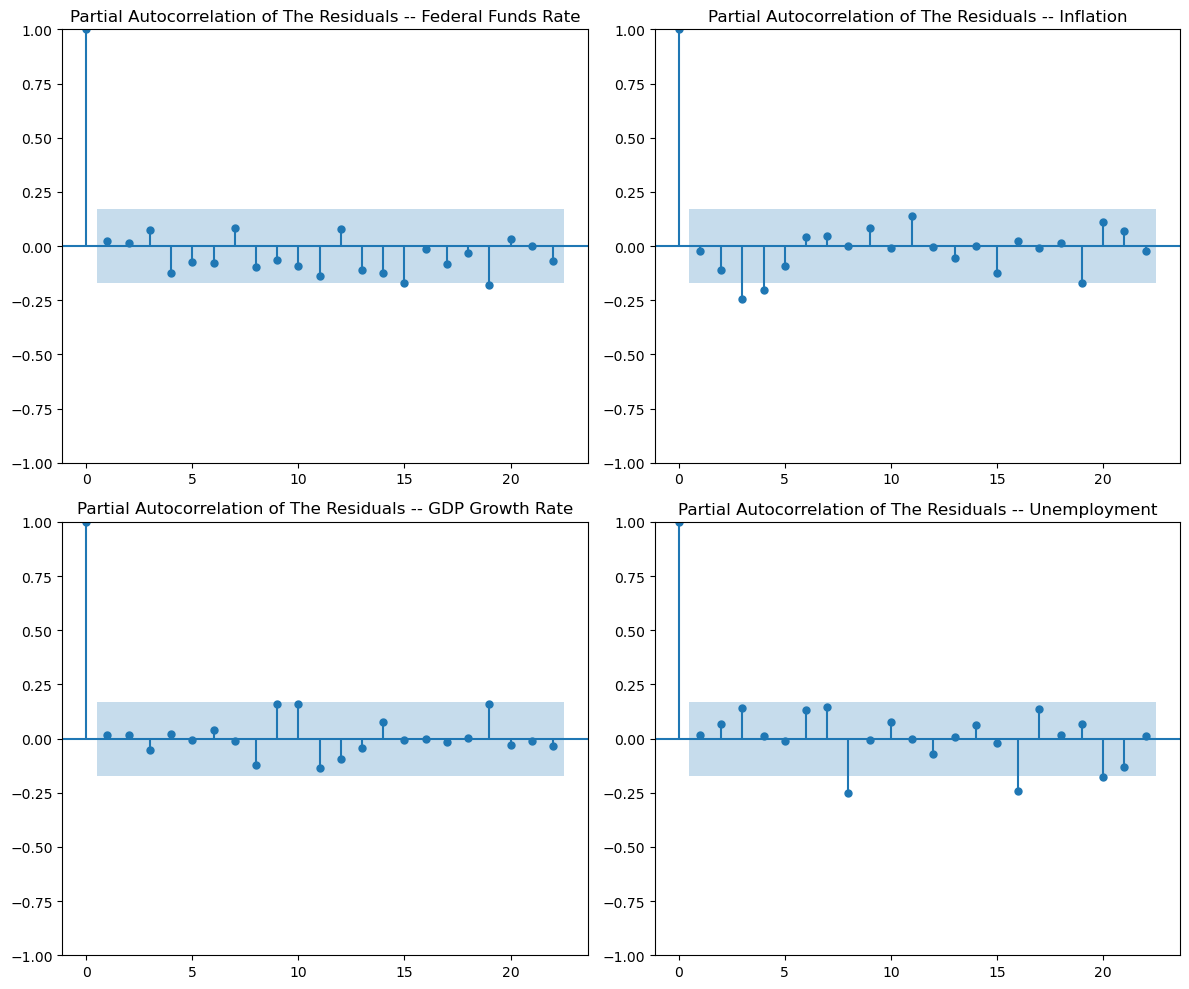

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plot_pacf(results.resid.fedfunds, ax=axs[0,0], title=f'Partial Autocorrelation of The Residuals -- Federal Funds Rate')
plot_pacf(results.resid.infl, ax=axs[0,1], title=f'Partial Autocorrelation of The Residuals -- Inflation')
plot_pacf(results.resid.gdp, ax=axs[1,0], title=f'Partial Autocorrelation of The Residuals -- GDP Growth Rate')
plot_pacf(results.resid.unrate, ax=axs[1,1] ,title=f'Partial Autocorrelation of The Residuals -- Unemployment')
plt.tight_layout()

In [25]:
for i in results.resid:
    print(f'\nLjung-Box test for residuals of {i}\n', sm.stats.acorr_ljungbox(results.resid[f'{i}'], lags=[12], return_df=True))
    if sm.stats.acorr_ljungbox(results.resid[f'{i}'], lags=[12], return_df=True).lb_pvalue.to_numpy() > 0.05:
        print('Residuals are independently distributed')
    else:
        print('Residuals are serially correlated')


Ljung-Box test for residuals of fedfunds
     lb_stat  lb_pvalue
12   11.645   0.474595
Residuals are independently distributed

Ljung-Box test for residuals of infl
       lb_stat  lb_pvalue
12  20.523387   0.057811
Residuals are independently distributed

Ljung-Box test for residuals of gdp
       lb_stat  lb_pvalue
12  12.471977   0.408557
Residuals are independently distributed

Ljung-Box test for residuals of unrate
       lb_stat  lb_pvalue
12  17.894528   0.118931
Residuals are independently distributed


Residuals of inflation barely survived the Ljung-Box test, and as can be seen from the partial autocorrelation graphs, they do seem to be serially correlated, however, we want to make inference on the coefficients of the unrate equation, so this is not going to be a problem.

# Structural Analysis

In [15]:
phi = results.params.iloc[0:1]

In [16]:
A1 = results.params.iloc[1:5]

In [17]:
A2 = results.params.iloc[5:]

In [18]:
phi

,fedfunds,infl,gdp,unrate
const,-0.014488,0.000052,0.003608,0.073303


In [19]:
A1

,fedfunds,infl,gdp,unrate
L1.fedfunds,0.616899,0.000660,-0.000589,-0.016459
L1.infl,-21.459568,-0.494361,-0.002787,-22.462236
L1.gdp,9.846056,0.012362,0.257509,-10.669180
L1.unrate,-0.374028,-0.001675,-0.001960,0.397733


In [20]:
A2

,fedfunds,infl,gdp,unrate
L2.fedfunds,-0.010224,-0.000344,0.001498,-0.039780
L2.infl,-3.637543,-0.289114,0.123492,-17.159762
L2.gdp,-11.225723,-0.025762,0.181802,-2.866940
L2.unrate,0.151818,0.001764,0.001137,0.130861


In [21]:
Lambda = results.sigma_u.to_numpy()

In [22]:
P = np.linalg.cholesky(Lambda)

In [23]:
P

array([[ 0.3200473 ,  0.        ,  0.        ,  0.        ],
       [ 0.00033412,  0.00138579,  0.        ,  0.        ],
       [ 0.00158783,  0.00114291,  0.00492164,  0.        ],
       [-0.04826056, -0.01015972, -0.06875851,  0.15847595]])

In [24]:
J = np.block([[A1.to_numpy(),A2.to_numpy()],[np.identity(4),np.zeros((4,4))]])

In [25]:
J

array([[ 6.16899268e-01,  6.60319167e-04, -5.89392703e-04,
        -1.64589248e-02, -1.02237301e-02, -3.44146578e-04,
         1.49848182e-03, -3.97795944e-02],
       [-2.14595683e+01, -4.94361327e-01, -2.78728938e-03,
        -2.24622360e+01, -3.63754259e+00, -2.89113969e-01,
         1.23491782e-01, -1.71597616e+01],
       [ 9.84605572e+00,  1.23621264e-02,  2.57508525e-01,
        -1.06691795e+01, -1.12257229e+01, -2.57624359e-02,
         1.81802046e-01, -2.86693951e+00],
       [-3.74027648e-01, -1.67518081e-03, -1.96049425e-03,
         3.97732758e-01,  1.51818380e-01,  1.76449186e-03,
         1.13723206e-03,  1.30860640e-01],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.000000

In [26]:
np.linalg.eig(J)

EigResult(eigenvalues=array([-0.30717753+0.45883334j, -0.30717753-0.45883334j,
        0.73917236+0.j        ,  0.54811238+0.1073269j ,
        0.54811238-0.1073269j , -0.26750672+0.j        ,
       -0.08787805+0.08173206j, -0.08787805-0.08173206j]), eigenvectors=array([[ 5.08797618e-04+1.17898884e-04j,  5.08797618e-04-1.17898884e-04j,
         1.33931293e-02+0.00000000e+00j,  1.17529029e-03+5.41426889e-03j,
         1.17529029e-03-5.41426889e-03j,  9.37158575e-04+0.00000000e+00j,
        -9.31496923e-05-3.49419313e-04j, -9.31496923e-05+3.49419313e-04j],
       [-2.68739818e-01+4.01418643e-01j, -2.68739818e-01-4.01418643e-01j,
         2.34756521e-01+0.00000000e+00j,  3.62532640e-02-1.68650463e-01j,
         3.62532640e-02+1.68650463e-01j, -1.47557442e-01+0.00000000e+00j,
        -8.57496042e-02+7.97524795e-02j, -8.57496042e-02-7.97524795e-02j],
       [ 1.36645983e-02-9.99225905e-03j,  1.36645983e-02+9.99225905e-03j,
         5.45744639e-01+0.00000000e+00j, -4.47535360e-01-8.76327314

As we can see, all eigenvalues are inside the unit circle.

Here we define the selection matrix $R_1$

In [27]:
R1 = np.block([[np.identity(4),np.zeros((4,4))]]).T

In [28]:
R1

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [29]:
J1 = R1.T @ J @ R1

$C_k$, the matrix of dynamic multipliers is defined as:
$
C_k \equiv \left( R_1^{T} J^k R_1 \right) P
$

In [30]:
for i in range(0,5):
    C = np.linalg.matrix_power(J1,i) @ P
    print(C[3,0].round(3), C[3,1].round(3), C[3,2].round(3))

-0.048 -0.01 -0.069
-0.139 -0.004 -0.027
-0.127 -0.002 -0.015
-0.106 -0.001 -0.007
-0.076 -0.001 -0.005


# Impulse-Response Analysis

In [31]:
irf = results.irf(20)

When calling the plot method of the irf object we set orth equal to True to make sure that the impulse response functions are plotted respecting the Cholesky ordering of the variables. The seed is also set to make sure the confidence bands are plotted consistently in every instance the code is run.

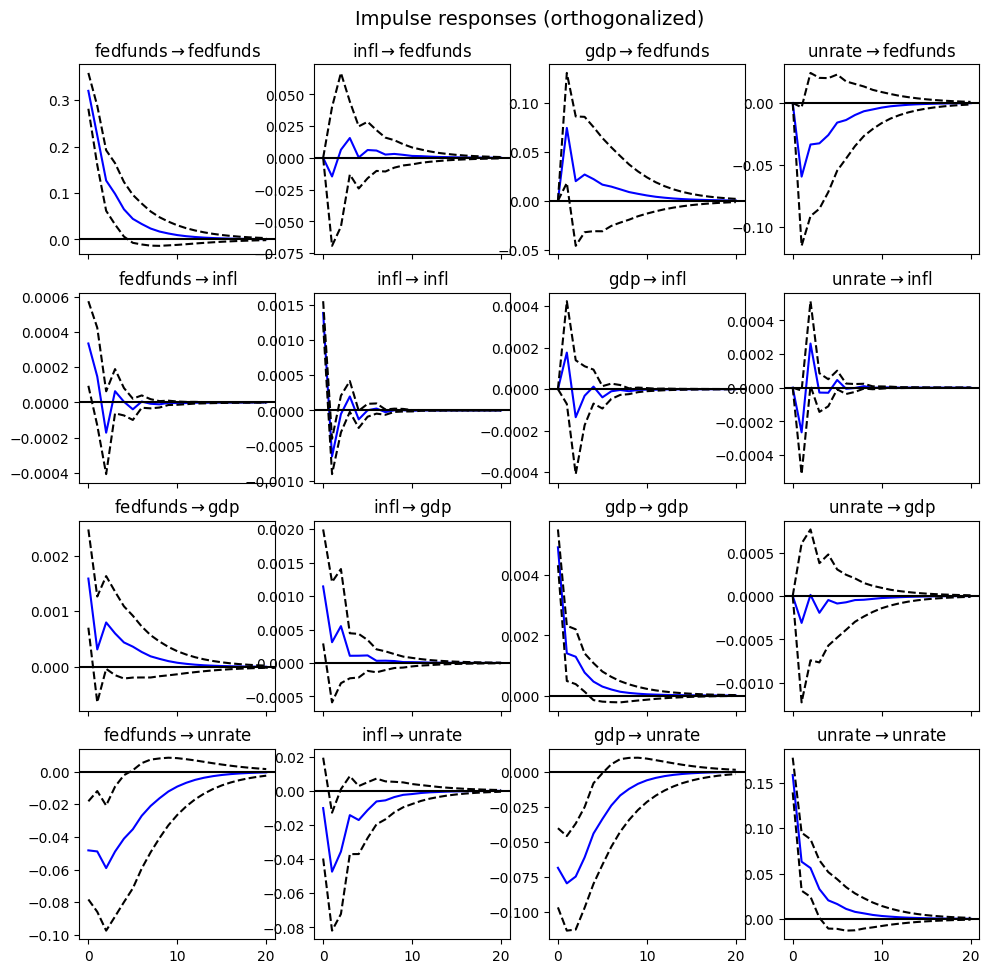

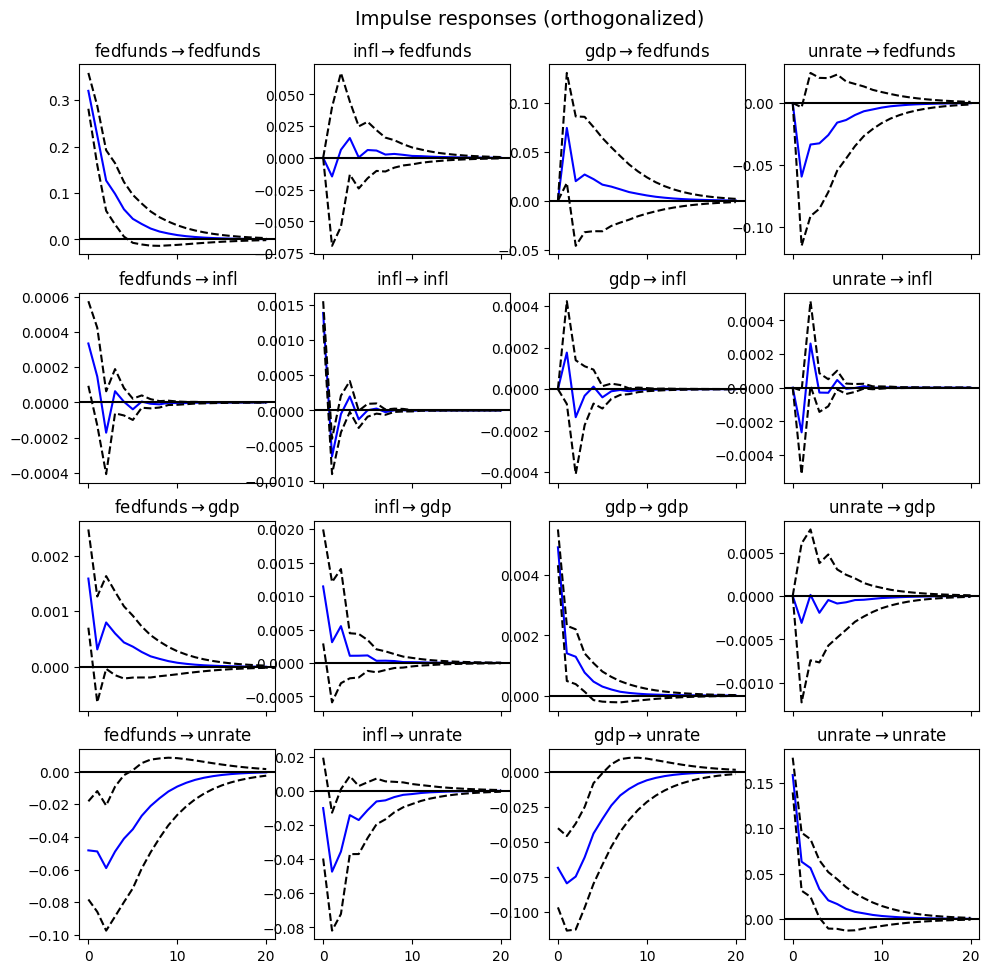

In [32]:
irf.plot(orth=True, seed=1776, signif = 0.05)